# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import f1_score

from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline

# Model Evaulation and Scoring
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Load in your data from kaggle.

In [2]:
train = pd.read_csv('../input/climatechangeedsa202021/train.csv')
test = pd.read_csv('../input/climatechangeedsa202021/test.csv')


Label sentiments
* Pro = 1
* Neutral = 0
* Anti = -1
* News = 2

Variable definitions

* sentiment = sentiment of tweet
* message = tweet body
* tweetid = twitter unique id

In [3]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

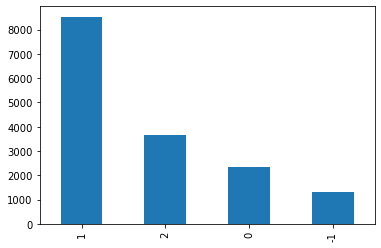

In [4]:
#display value counts in a bar chart
train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [5]:
print(train.shape) 
print(test.shape)

(15819, 3)
(10546, 2)


In [6]:
display(train.head())
display(test.head())

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Text Cleaning

In [7]:
#removing the web-urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

#remove punctuation and change to lower case
train['message'] = train['message'].str.lower()

print(string.punctuation)

def remove_punctuation(message):
    return ''.join([l for l in message if l not in string.punctuation])

train['message'] = train['message'].apply(remove_punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
def update(df):
    df = train.copy()
    sentiment = df['sentiment']
    word_sentiment = []

    for i in sentiment :
        if i == 1 :
            word_sentiment.append('Pro')
        elif i == 0 :
            word_sentiment.append('Neutral')
        elif i == -1 :
            word_sentiment.append('Anti')
        else :
            word_sentiment.append('News')

    df['sentiment'] = word_sentiment
    
    return df

In [9]:
df = update(train)
df.head()

,sentiment,message,tweetid
0,Pro,polyscimajor epa chief doesnt think carbon dio...,625221
1,Pro,its not like we lack evidence of anthropogenic...,126103
2,News,rt rawstory researchers say we have three year...,698562
3,Pro,todayinmaker wired 2016 was a pivotal year in...,573736
4,Pro,rt soynoviodetodas its 2016 and a racist sexis...,466954


# Speech Tagging & Lemmatization

* Modifies original train dataframe
* Extra Column for length of each Tweet
* Tweets tokenized, tagged and Lemmatized

In [10]:
def lem(df):
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

def get_wordnet_position(tag):
    if tag.startswith('J'):
        return wordnet.ADJ

    elif tag.startswith('V'):
        return wordnet.VERB

    elif tag.startswith('N'):
          return wordnet.NOUN

    elif tag.startswith('R'):
          return wordnet.ADV
        
    else:
        return wordnet.NOUN
        
    wl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lem(df)

# Splitting the training data into a training and validation set

In [11]:
y = train['sentiment']
X = train['message']

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=10)

# Training the model and evaluating using the validation set

In [13]:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

In [14]:
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

# Checking the performance of our model on the validation set

In [15]:
print(metrics.classification_report(y_valid, y_pred_lsvc))

              precision    recall  f1-score   support

          -1       0.61      0.49      0.55       397
           0       0.57      0.48      0.52       732
           1       0.80      0.81      0.80      2501
           2       0.74      0.82      0.78      1116

    accuracy                           0.74      4746
   macro avg       0.68      0.65      0.66      4746
weighted avg       0.73      0.74      0.73      4746



In [16]:
lsvc_op = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8,
                                                    min_df=2,
                                                    ngram_range=(1,2))),
                  ('clf', LinearSVC(C=0.3,
                                    class_weight='balanced',
                                    max_iter=3000))])

# Fit and predict
lsvc_op.fit(X_train, y_train)
y_pred = lsvc_op.predict(X_valid)

print('F1 score improved by',
      round(100*((metrics.accuracy_score(y_pred, y_valid) - metrics.accuracy_score(y_pred_lsvc, y_valid)) /metrics.accuracy_score(y_pred_lsvc, y_valid)),0), 
      '%')

F1 score improved by 1.0 %


# Creating an output csv for submission

In [17]:
y_test = lsvc_op.predict(test['message'])
output = pd.DataFrame({'tweetid': test.tweetid,
                       'sentiment': y_test})
output.to_csv('testsubmission.csv', index=False)